# Topic Contiguity 

Topic contiguity refers to the relationship of topics to each other in practice, not to their similarity. From the perspective of an associationist epistemology, contiguity is the opposite of similarity. Contiguous topics are those that co-occur frequently enough to suggest "syndromes." For example, if the topics of genetic engineering and acquaculture are contiguous, this suggests an assemblage of practices relating to the application of a kind of knowledge to a specific industry. We use pointwise mutual information  to surface topic contiguity, similar to how this concept is used in association rule mining.

# Set Up

## Imports

In [1]:
import pandas as pd
import numpy as np
from lib import tapi

## Configuration

In [2]:
tapi.list_dbs()

/Users/rca2t1/Dropbox/Courses/NEH/TAPI_Topic_Models


['jstor_hyperparameter_demo',
 'pitchfork',
 'poliblogs2008',
 'tamilnet',
 'winereviews']

In [3]:
# data_prefix = 'jstor_hyperparameter_demo'
# topic_glosses = ['Bayesian models', 'French', 'MCMC', 'priors', 'economics', 'random effects', 'variable selection',
#                  'empirical Bayes', 'env biology', 'genetics']

In [2]:
data_prefix = 'ussc'
topic_glosses = []

In [3]:
# data_prefix = 'tamilnet'
# topic_glosses = []

## Import Topic Data

We import our previously generated model.

In [4]:
db = tapi.Edition(data_prefix)

In [5]:
db.get_tables()

./db/ussc-LABELS.csv
LABELS
./db/ussc-VOCAB.csv
VOCAB
./db/ussc-BOW.csv
BOW
./db/ussc-TOPICS.csv
TOPICS
./db/ussc-DTM.csv
DTM
./db/ussc-THETA.csv
THETA
./db/ussc-PHI.csv
PHI
./db/ussc-TOPICS_NMF.csv
TOPICS_NMF
./db/ussc-THETA_NMF.csv
THETA_NMF
./db/ussc-PHI_NMF.csv
PHI_NMF


In [6]:
if len(topic_glosses) > 0:
    db.TOPICS_NMF['gloss'] = topic_glosses
else:
    db.TOPICS_NMF['gloss'] = db.TOPICS_NMF.topwords.str.extract(r'^(.{20})')

# Compute Contiguity

## By Correlation

### Create Topic Pairs

In [7]:
topic_pairs = db.THETA_NMF.corr().stack().to_frame('topic_corr') # Normalized dot product
topic_pairs.index.names = ['t1', 't2']
topic_pairs = topic_pairs.loc[topic_pairs.apply(lambda x: x.name[0] < x.name[1], 1)]

topic_pairs['z_score'] = (topic_pairs.topic_corr - topic_pairs.topic_corr.mean()) / topic_pairs.topic_corr.std()
topic_pairs['t1_gloss'] = topic_pairs.apply(lambda x: db.TOPICS_NMF.loc[x.name[0]].gloss, 1)
topic_pairs['t2_gloss'] = topic_pairs.apply(lambda x: db.TOPICS_NMF.loc[x.name[1]].gloss, 1)

In [8]:
topic_pairs.sort_values('topic_corr', ascending=False).head(10)

topic_corr   z_score              t1_gloss              t2_gloss
t1 t2                                                                  
6  20    0.317978  6.517261  6 religious, religio  20 school, schools, 
5  14    0.268851  5.560516  5 tax, income, taxes  14 commerce, interst
13 27    0.234736  4.896119  13 states, united st  27 congress, act, st
7  8     0.231652  4.836051  7 union, labor, boar  8 arbitration, contr
1  22    0.206828  4.352604  1 mr justice, mr, ju  22 mr justice black,
2  15    0.203999  4.297514  2 trial, defendant,   15 jury, grand, gran
10 15    0.164305  3.524459  10 death, penalty, d  15 jury, grand, gran
12 19    0.154210  3.327865  12 voting, districts  19 equal protection,
0  11    0.153656  3.317074  0 court, district, c  11 habeas, habeas co
1  28    0.149179  3.229871  1 mr justice, mr, ju  28 xxx, mr justice,

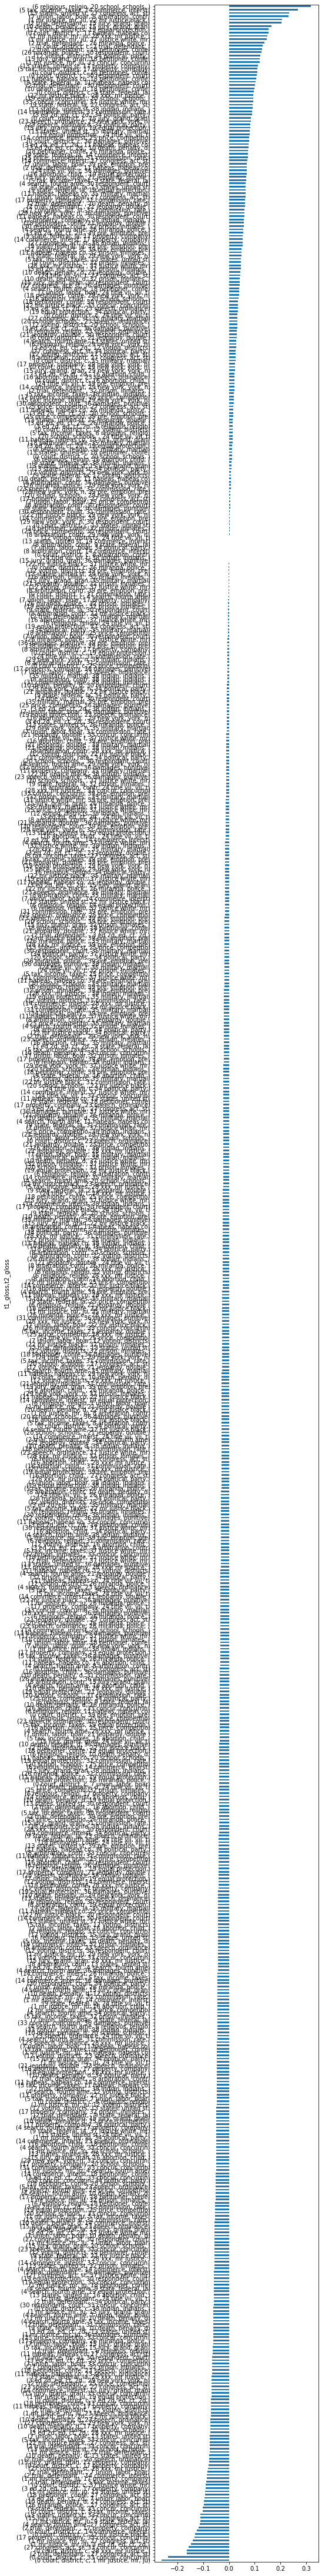

In [9]:
topic_pairs.reset_index().set_index(['t1_gloss','t2_gloss']).topic_corr.sort_values()\
    .plot.barh(figsize=(5, db.n_topics * 2), legend=False);

### View Network

In [10]:
import pydot
from IPython.display import SVG, display

In [11]:
def show_graph(quantile=.5, measure='topic_corr'):
    
    thresh = topic_pairs[measure].quantile(quantile)
    
    graph = pydot.Dot('topic_graph', graph_type='graph')

    nodes = []
    for i in topic_pairs[topic_pairs[measure] >= thresh].index:

        nodes.append(i[0])
        nodes.append(i[1])

        m = topic_pairs.loc[i][measure].round(2)    
        graph.add_edge(pydot.Edge(i[0], i[1], 
                                  label=m, 
                                  color='lightgray', 
                                  fontsize=10, 
                                  fontcolor='green',
                                  fontname='Arial'))

    for node in list(set(nodes)):
        node_gloss = 'T' + str(node) + ": " + db.TOPICS_NMF.loc[node, 'gloss']
        graph.add_node(pydot.Node(node, 
                                  label=node_gloss, 
                                  shape='plain', 
                                  fontname='Arial'))

    display(SVG(graph.create_svg()))

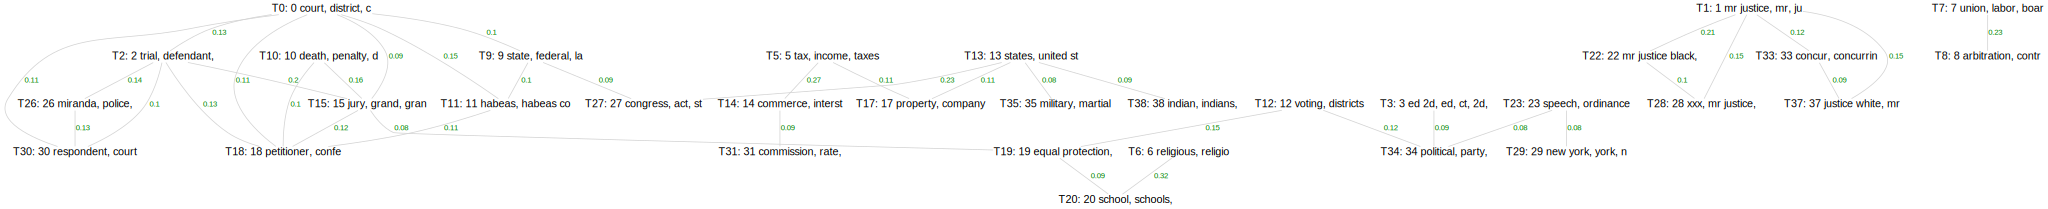

In [14]:
show_graph(.95)

## By Mutual Information

### Compute Marginal Probabilities

In [15]:
# db.TOPICS_NMF['p'] = db.THETA_NMF.sum() / db.THETA_NMF.sum().sum()

In [16]:
db.TOPICS_NMF['p'] = db.PHI_NMF.T.sum() / db.PHI_NMF.T.sum().sum()

### Compute Joint Probabilities

In [17]:
tw_thresh = 0

In [18]:
N = db.THETA_NMF.shape[0]

In [19]:
topic_pairs['p_ab'] = topic_pairs.apply(lambda x: 
                                        db.THETA_NMF[(db.THETA_NMF[x.name[0]] > tw_thresh) 
                                        & (db.THETA_NMF[x.name[1]] > tw_thresh)].shape[0] / N, 1)

In [20]:
topic_pairs.sort_values('p_ab', ascending=False).head(10)

topic_corr   z_score              t1_gloss              t2_gloss  \
t1 t2                                                                     
0  27   -0.034367 -0.344703  0 court, district, c  27 congress, act, st   
   9     0.096042  2.195021  0 court, district, c  9 state, federal, la   
   13    0.002863  0.380360  0 court, district, c  13 states, united st   
   33   -0.235327 -4.258427  0 court, district, c  33 concur, concurrin   
   1    -0.260732 -4.753191  0 court, district, c  1 mr justice, mr, ju   
   3    -0.068888 -1.017012  0 court, district, c  3 ed 2d, ed, ct, 2d,   
   2     0.131147  2.878701  0 court, district, c  2 trial, defendant,    
13 27    0.234736  4.896119  13 states, united st  27 congress, act, st   
0  17   -0.078599 -1.206128  0 court, district, c  17 property, company   
9  27    0.092981  2.135412  9 state, federal, la  27 congress, act, st   

           p_ab  
t1 t2            
0  27  0.573527  
   9   0.488195  
   13  0.485406  
   33  0.441160  
   1   0.402863  
   3   0.358245  
   2   0.356944  
13 27  0.349321  
0  17  0.331102  
9  27  0.315114

### Compute PWMI


**From Bouma:**

"Pointwise  mutual  information  (PMI,  5)  is  a  measure  of  how  much  the  actual probability of a particular co-occurrence of events $p(x, y)$ differs from what we would expect it to be on the basis of the probabilities of the individual events and the assumption of independence $p(x)$ $p(y)$."

[Bouma, Gerlof (2009). "Normalized (Pointwise) Mutual Information in Collocation Extraction." _Proceedings of the Biennial GSCL Conference_.](https://svn.spraakdata.gu.se/repos/gerlof/pub/www/Docs/npmi-pfd.pdf)

**From Raviv:**

"The pointwise mutual information can be understood as a scaled conditional probability."

"Pointwise mutual information measure is not confined to the $[0,1]$ range. So here we explain how to interpret a zero, a positive or, as it is in our case, a negative number. The case where $PMI=0$ is trivial. It occurs for $log(1) =0$ and it means that $p(x,y) = p(x)p(y)$ which tells us that $x$ and $y$ are independents. If the number is positive it means that the two events co-occuring in a frequency higher than what we would expect if they would be independent event. Why? because $p(y \vert x) \times \frac{1}{p(x)}$ (or equivalently $p(x \vert y) \times \frac{1}{p(y)})$ is larger than $1$ (if it’s smaller than $1$, the log is negative). In our case the number is lower than one, meaning $p(y \vert x) < p(x)$ which means we see more of $X=x$ than we see $y$ given that $X=x$. 

https://eranraviv.com/understanding-pointwise-mutual-information-in-statistics/

In [21]:
import math

In [22]:
def pwmi(p_a, p_b, p_ab):
    """Computes the adjusted point-wise mutual information of two items (a and b)
    that appear in container vectors of some kind, e.g. items in a shopping
    basket."""

    if p_ab > 0:
        pmi_ab = math.log2(p_ab / (p_a * p_b))  # Raw
        i = math.log2(1/p_ab)                   # Surprise (info) 
        h = p_ab * i                            # Entropy
#         apmi_ab = pmi_ab / h                    # Adjusted
        npmi_ab = pmi_ab / i                    # Normalized
    else:
#         apmi_ab = 0
        npmi_ab = 0

    return npmi_ab

In [23]:
topic_pairs['pwmi'] = topic_pairs.apply(lambda x: pwmi(db.TOPICS_NMF.loc[x.name[0]].p, 
                                                       db.TOPICS_NMF.loc[x.name[1]].p,
                                                      x.p_ab), 1)

In [24]:
topic_pairs.sort_values('pwmi', ascending=False).head(10)

topic_corr   z_score              t1_gloss              t2_gloss  \
t1 t2                                                                     
0  27   -0.034367 -0.344703  0 court, district, c  27 congress, act, st   
   9     0.096042  2.195021  0 court, district, c  9 state, federal, la   
   13    0.002863  0.380360  0 court, district, c  13 states, united st   
   1    -0.260732 -4.753191  0 court, district, c  1 mr justice, mr, ju   
   33   -0.235327 -4.258427  0 court, district, c  33 concur, concurrin   
1  33    0.118671  2.635732  1 mr justice, mr, ju  33 concur, concurrin   
13 27    0.234736  4.896119  13 states, united st  27 congress, act, st   
9  27    0.092981  2.135412  9 state, federal, la  27 congress, act, st   
0  2     0.131147  2.878701  0 court, district, c  2 trial, defendant,    
1  13   -0.091539 -1.458135  1 mr justice, mr, ju  13 states, united st   

           p_ab      pwmi  
t1 t2                      
0  27  0.573527  7.504289  
   9   0.488195  6.554639  
   13  0.485406  6.325779  
   1   0.402863  5.865558  
   33  0.441160  5.769701  
1  33  0.258784  4.705058  
13 27  0.349321  4.659869  
9  27  0.315114  4.260540  
0  2   0.356944  4.072883  
1  13  0.228295  4.054956

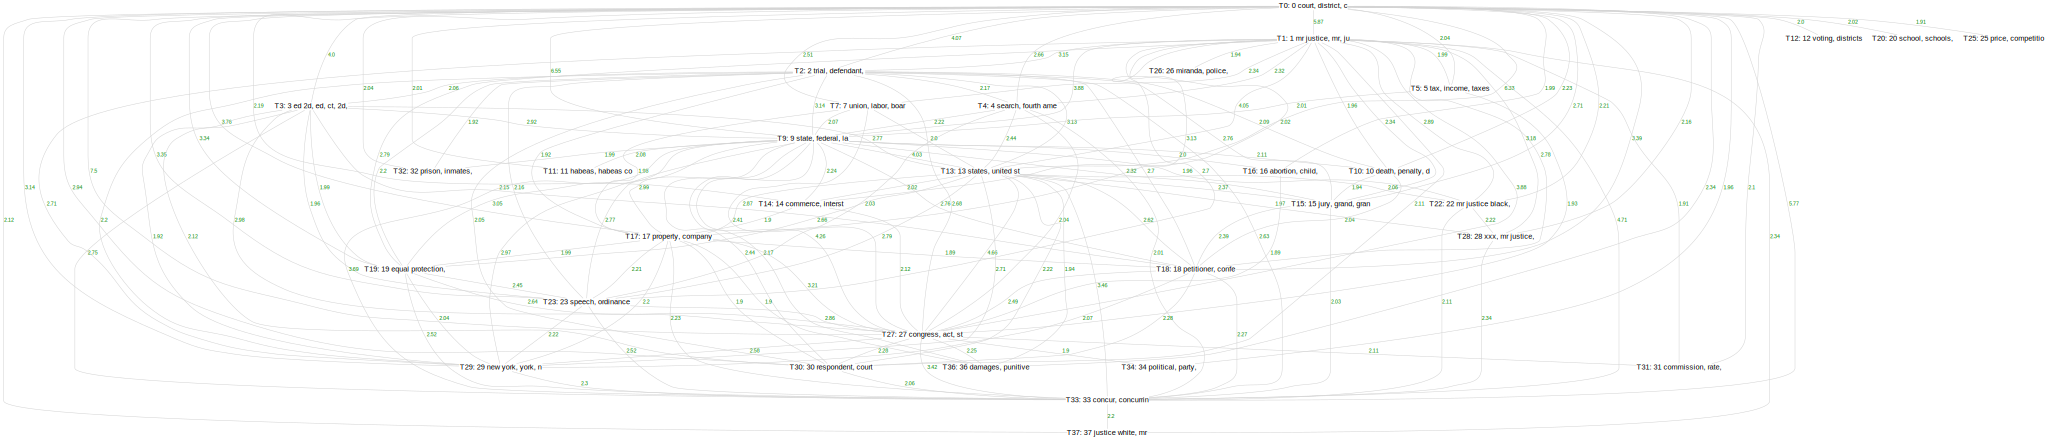

In [26]:
show_graph(.8, 'pwmi')

## Compare Contiguity Measures

In [27]:
import plotly_express as px

In [28]:
labels = topic_pairs[['t1_gloss','t2_gloss']].apply(lambda x: '<br>'.join(x), 1)

In [29]:
px.scatter(topic_pairs, 'topic_corr', 'pwmi', size='p_ab', text=labels, height=1000, width=1000)

In [30]:
px.scatter_3d(topic_pairs, 'topic_corr', 'pwmi', 'p_ab', text=labels, height=1000, width=1000)

$\theta$ $\phi$